<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/bag_of_logistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 108 (delta 56), reused 26 (delta 11), pack-reused 0
Receiving objects: 100% (108/108), 13.46 MiB | 8.00 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [93]:
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
import numpy as np
import torch
from torch import distributions
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets
from torchvision import transforms

In [94]:
BATCH_SIZE=512

transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.view(-1),
    lambda x: distributions.Bernoulli(probs=x).sample()])

trainloader = data.DataLoader(
    datasets.MNIST(
        root='../data', train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, 
    num_workers=2)
 
testloader = data.DataLoader(
    datasets.MNIST(
        root='../data', train=False, download=True, transform=transform),
    batch_size=BATCH_SIZE, 
    num_workers=2)

In [114]:
class MeanLayer(nn.Module):
  """Linear layer which only models the mean of the labels.

  This is achieved by only having a bias parameter which does not depend on 
  any data. N.B. that the dimension of the bias is hardcoded to be 1.
  """

  def __init__(self):
    super().__init__()
    self._bias = torch.nn.Parameter(data=torch.zeros((1,)))

  def forward(self, x):
    """Computes the forward pass.
    
    IMPORTANT: The input is not used in the forward pass computation but must
    be provided to determine the batch size.
    """
    batch_size = x.shape[0]
    return torch.ones((batch_size, 1)) * self._bias

class BagOfLogistics(nn.Module):
  """."""

  def __init__(self, features):
    super().__init__()

    self._features = features

    linears = [MeanLayer()]
    for i in range(1, self._features):
      linears.append(nn.Linear(in_features=i, out_features=1))
    self._linears = nn.ModuleList(linears)

  def forward(self, x):
    output = [self._linears[0](x[:, :1])]
    for i in range(1, self._features):
      output.append(self._linears[i](x[:, :i]))
    output = torch.stack(output, axis=1).squeeze(dim=-1)
    return torch.sigmoid(output)

  def sample(self, conditioned_on=None):
    with torch.no_grad():
      if conditioned_on is None:
        device = next(self.parameters()).device
        conditioned_on = (torch.ones((1, self._features)) * - 1).to(device)
      else:
        conditioned_on = conditioned_on.clone()

      for dim in range(self._features):
        # TODO(eugenhotaj): We're wasting massive amounts of computation here
        # by doing a full forward pass through all models for each dimension. 
        # We can instead do the same thing we did in forward.
        out = self.forward(conditioned_on)[:, dim]
        out = distributions.Bernoulli(probs=out).sample()
        conditioned_on[:, dim] = torch.where(
            conditioned_on[:, dim] < 0, out, conditioned_on[:, dim])
      return conditioned_on 

In [116]:
INPUT_SIZE = 784
N_EPOCHS = 50

model = BagOfLogistics(INPUT_SIZE,).to(colab_utils.get_device())
# TODO(eugenhotaj): Since all the underlying logistic models are disjoint, it
# would be more optimal to have one optimizer per model. However, this adds 
# quite a bit of complexity to the training process. Using adaptive optimizers
# also mitigates this issue someone since each parameter will get its own 
# learning rate.
optimizer = optim.Adam(model.parameters())
bce_loss_fn = nn.BCELoss(reduction='none')
loss_fn = lambda x, y, preds: bce_loss_fn(preds, x).sum(dim=1).mean()

train_losses, eval_losses = colab_utils.train_andor_evaluate(
    model, 
    loss_fn, 
    optimizer=optimizer, 
    n_epochs=N_EPOCHS, 
    train_loader=trainloader,
    eval_loader=testloader,
    device=colab_utils.get_device())

[1|1796]: train_loss=342.28421095377604 eval_loss=282.7946029296875
[2|1805]: train_loss=266.21285200195314 eval_loss=249.74182404785157
[3|1795]: train_loss=240.80256975097657 eval_loss=229.90232705078125
[4|1792]: train_loss=223.7373075846354 eval_loss=215.20296689453124
[5|1808]: train_loss=210.46316151529948 eval_loss=203.44412036132812
[6|1779]: train_loss=199.59648662109376 eval_loss=193.46713591308594
[7|1794]: train_loss=190.3882016845703 eval_loss=185.00503876953124
[8|1797]: train_loss=182.2994200439453 eval_loss=177.5134095703125
[9|1801]: train_loss=175.2721121500651 eval_loss=170.9085322265625
[10|1799]: train_loss=168.98715891927083 eval_loss=165.08293762207032
[11|1795]: train_loss=163.3683205810547 eval_loss=159.72227004394531
[12|1801]: train_loss=158.29717920735678 eval_loss=154.98139685058592
[13|1798]: train_loss=153.7454821126302 eval_loss=150.67543576660157
[14|1797]: train_loss=149.59134009602866 eval_loss=146.6785751953125
[15|1788]: train_loss=145.8382670654296

In [118]:
model_weights = model.state_dict()
model = BagOfLogistics(INPUT_SIZE,).to(colab_utils.get_device())
model.load_state_dict(model_weights)

<All keys matched successfully>

In [120]:
a = model.sample()

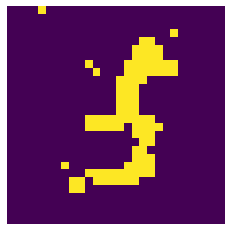

In [123]:
colab_utils.imshow(a.reshape(28, 28))